In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gowthamkumar1626","key":"2fca20f08f11cdf20cf98099fde3ecf3"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

2.5.0


In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.70G/2.70G [00:42<00:00, 40.6MB/s]
100% 2.70G/2.70G [00:42<00:00, 68.3MB/s]


In [ ]:
import zipfile
import glob
import shutil
import os
import pathlib
import re

In [ ]:
# !unzip /content/new-plant-diseases-dataset.zip

with zipfile.ZipFile("/content/new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_dir = "/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid"

In [ ]:
data_dir = pathlib.Path(valid_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

17572


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Spider_mites Two-spotted_spider_mite/0e0d9560-41ee-45cf-8bea-8cddfdc04979___Com.G_SpM_FL 1159_180deg.JPG'
b'/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Pepper,_bell___Bacterial_spot/84d20d35-2bd6-4bab-aa96-d4dcc402dcf0___NREC_B.Spot 9228_180deg.JPG'
b'/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Blueberry___healthy/0c87d5fc-df11-4e63-9f07-5220444bef41___RS_HL 0410.JPG'
b'/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Tomato_Yellow_Leaf_Curl_Virus/ad7295b8-c903-48f5-b5cf-39d0bff831c5___YLCV_NREC 2470.JPG'
b'/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Tomato_Yellow_Leaf_Curl_Virus/c1d48af7-665a-436b-872a-2ccccf30e09b___YLCV_GCREC 2218.JPG'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

14058
3514


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  36


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

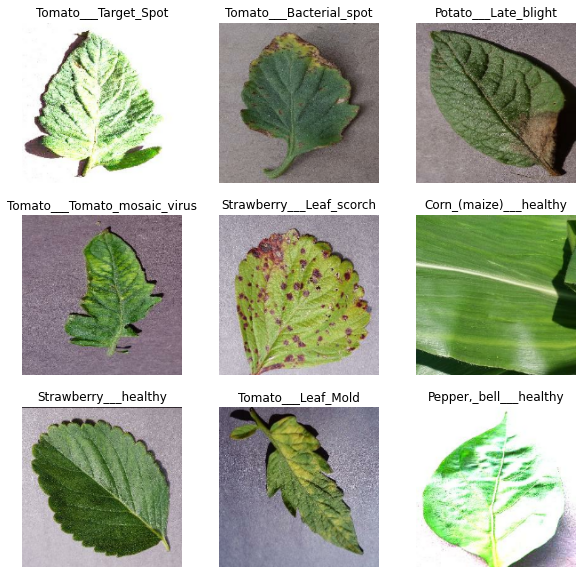

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(2048, activation='relu')(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [ ]:
epochs = 30

model = make_model(input_shape=(180, 180) + (3,), num_classes=len(class_names))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=loss, 
    optimizer=optimizer, 
    metrics=['accuracy']
)

callbacks_list = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks=callbacks_list,
    verbose = 1
)

Epoch 1/30
440/440 [==============================] - 123s 275ms/step - loss: 1.6194 - accuracy: 0.5160 - val_loss: 6.1202 - val_accuracy: 0.1076
Epoch 2/30
440/440 [==============================] - 121s 274ms/step - loss: 0.8204 - accuracy: 0.7392 - val_loss: 3.0912 - val_accuracy: 0.4573
Epoch 3/30
440/440 [==============================] - 121s 274ms/step - loss: 0.5645 - accuracy: 0.8158 - val_loss: 1.6355 - val_accuracy: 0.6192
Epoch 4/30
440/440 [==============================] - 120s 274ms/step - loss: 0.4231 - accuracy: 0.8607 - val_loss: 1.1486 - val_accuracy: 0.7035
Epoch 5/30
440/440 [==============================] - 121s 274ms/step - loss: 0.3307 - accuracy: 0.8902 - val_loss: 2.6146 - val_accuracy: 0.5211
Epoch 6/30
440/440 [==============================] - 120s 273ms/step - loss: 0.3048 - accuracy: 0.9003 - val_loss: 5.1094 - val_accuracy: 0.3241
Epoch 7/30
440/440 [==============================] - 121s 275ms/step - loss: 0.2454 - accuracy: 0.9197 - val_loss: 1.6368 -

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
440/440 [==============================] - 13s 28ms/step - loss: 2.1519 - accuracy: 0.3949 - val_loss: 1.3077 - val_accuracy: 0.6061
Epoch 2/20
440/440 [==============================] - 12s 28ms/step - loss: 0.9775 - accuracy: 0.7038 - val_loss: 0.9736 - val_accuracy: 0.7060
Epoch 3/20
440/440 [==============================] - 12s 28ms/step - loss: 0.6605 - accuracy: 0.7943 - val_loss: 0.7582 - val_accuracy: 0.7664
Epoch 4/20
440/440 [==============================] - 12s 28ms/step - loss: 0.4790 - accuracy: 0.8445 - val_loss: 0.7290 - val_accuracy: 0.7834
Epoch 5/20
440/440 [==============================] - 12s 28ms/step - loss: 0.3485 - accuracy: 0.8896 - val_loss: 0.7957 - val_accuracy: 0.7834
Epoch 6/20
440/440 [==============================] - 13s 29ms/step - loss: 0.2672 - accuracy: 0.9122 - val_loss: 0.8619 - val_accuracy: 0.7928
Epoch 7/20
440/440 [==============================] - 13s 29ms/step - loss: 0.1892 - accuracy: 0.9377 - val_loss: 0.9236 - val_accuracy:

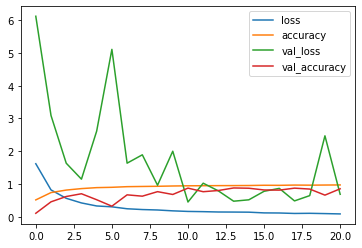

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.save("apple_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('apple_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import files

files.download("apple_model.h5")
files.download("apple_model.tflite")

In [ ]:
class_names = list(class_dict)
class_names

['Blueberry___healthy']

In [ ]:
path = "/content/Apple Scab.jpeg"


img = tf.keras.preprocessing.image.load_img(
    path, target_size=(180, 180)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array/255
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

FileNotFoundError: ignored

In [ ]:
model.save("apple_model.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('apple_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import files

files.download("apple_model.h5")
files.download("apple_model.tflite")

In [ ]:
class_names

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from pprint import pprint

In [ ]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    preprocessing_function = preprocess_input,
)

validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (150, 150),
    shuffle=True
)

validation_generator =  validation_datagen.flow_from_directory(
    valid_dir,
    batch_size  = batch_size,
    class_mode  = 'categorical',
    target_size = (150, 150),
    shuffle=True
)

In [ ]:
train_generator.num_classes

In [ ]:
class_dict = train_generator.class_indices
pprint(class_dict)

In [ ]:
class_list = list(class_dict.keys())
pprint(class_list)

In [ ]:
train_num = train_generator.samples
valid_num = validation_generator.samples

print(train_num)

In [ ]:
inception_model = InceptionV3(input_shape= (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')

densenet_model = DenseNet121(input_shape= (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')

In [ ]:
for layer in inception_model.layers:
    layer.trainable = False

In [ ]:
last_layer = inception_model.get_layer('mixed9')
print('Last Layer Output Shape:', last_layer.output_shape)
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(2048, activation='relu')(x)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(len(class_dict), activation='softmax')(x)

model = Model(inception_model.input, x)

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

In [ ]:
os.makedirs("/content/drive/MyDrive/checkpoint/", exist_ok=True)

In [ ]:
weightpath = "best_weights.hdf5"
checkpoint = ModelCheckpoint("/content/drive/MyDrive/checkpoint/", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint, tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_num//batch_size,
    validation_data = validation_generator,
    validation_steps=valid_num//batch_size,
    epochs = 20,
    callbacks=callbacks_list,
    verbose = 1
)

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Soybean___healthy/09644faa-41cd-4d2a-b4b9-e5495c873086___RS_HL 6211.JPG", target_size=(150, 150)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format("label", 100 * np.max(score))
# )

In [ ]:
predictions[0]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('inception_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import shutil

shutil.move("/content/New Plant Diseases Dataset(Augmented)/", "/content/drive/MyDrive/")